In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sim_name = 'TNG100-1'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [4]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [5]:
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('v200m')

sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')

In [6]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)
log_r_200m = np.log10(r_200m)
N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 19670


# MAH from Illustris Sublink

In [7]:
#sim_reader.add_MAH_to_halos_sublink()

In [8]:
def save_mah(halos, fn_mah):
    mah_dict = {}
    for halo in halos:
        mah_dict[halo.idx_halo_dark] = halo.catalog_properties['MAH']
    np.save(fn_mah, mah_dict)
    
def load_mah(halos, fn_mah):
    mah_dict = np.load(fn_mah, allow_pickle=True).item()
    for halo in halos:
        halo.set_catalog_property('MAH', mah_dict[halo.idx_halo_dark])

In [9]:
fn_mah = f'../data/mahs/mahs_sublink_{sim_name}{halo_tag}.npy'
# save_mah(sim_reader.dark_halo_arr, fn_mah)

In [10]:
load_mah(sim_reader.dark_halo_arr, fn_mah)

In [11]:
np.random.seed(14)
rand_idxs = np.random.randint(len(sim_reader.dark_halo_arr), size=10)

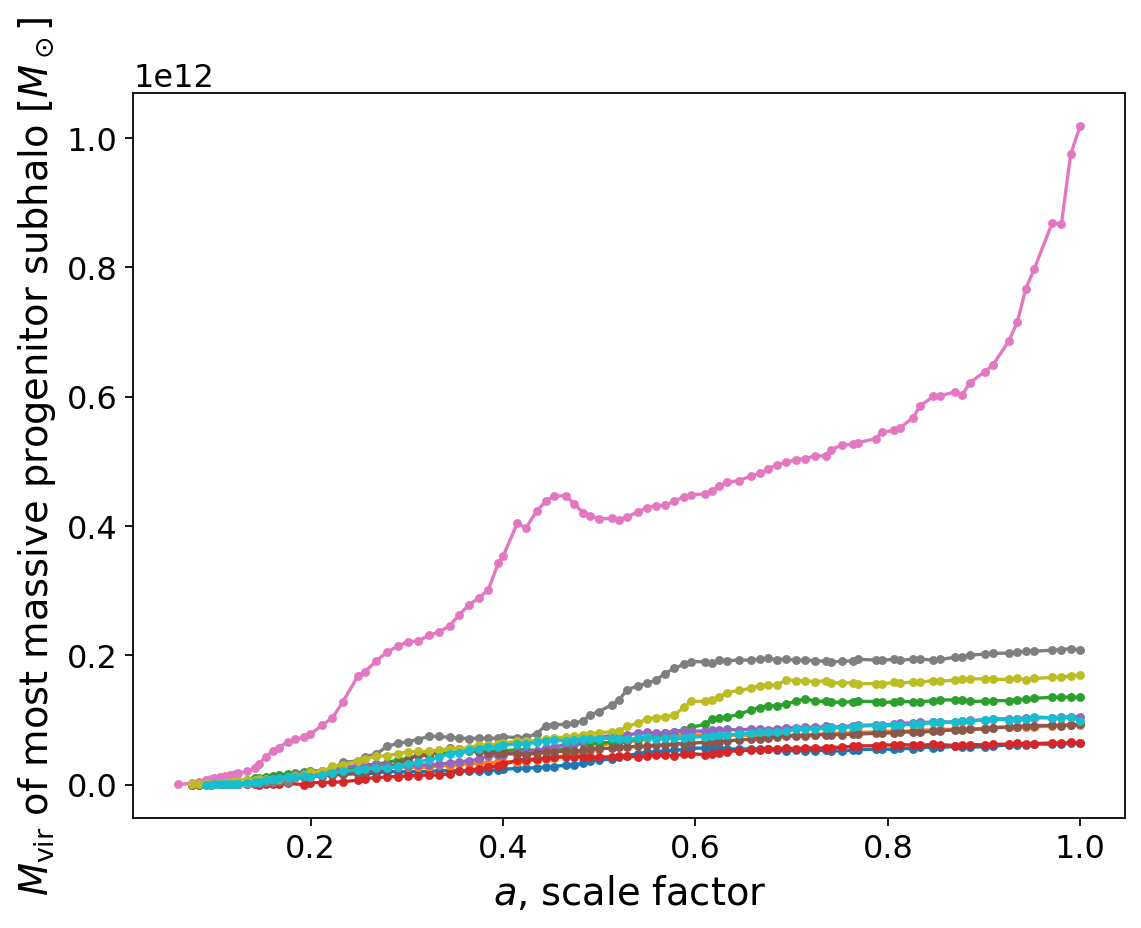

In [12]:
plt.figure(figsize=(8,6))
for i in rand_idxs:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah*mass_multiplier, marker='o', markersize=3)
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}$ of most massive progenitor subhalo [$M_\odot$]')

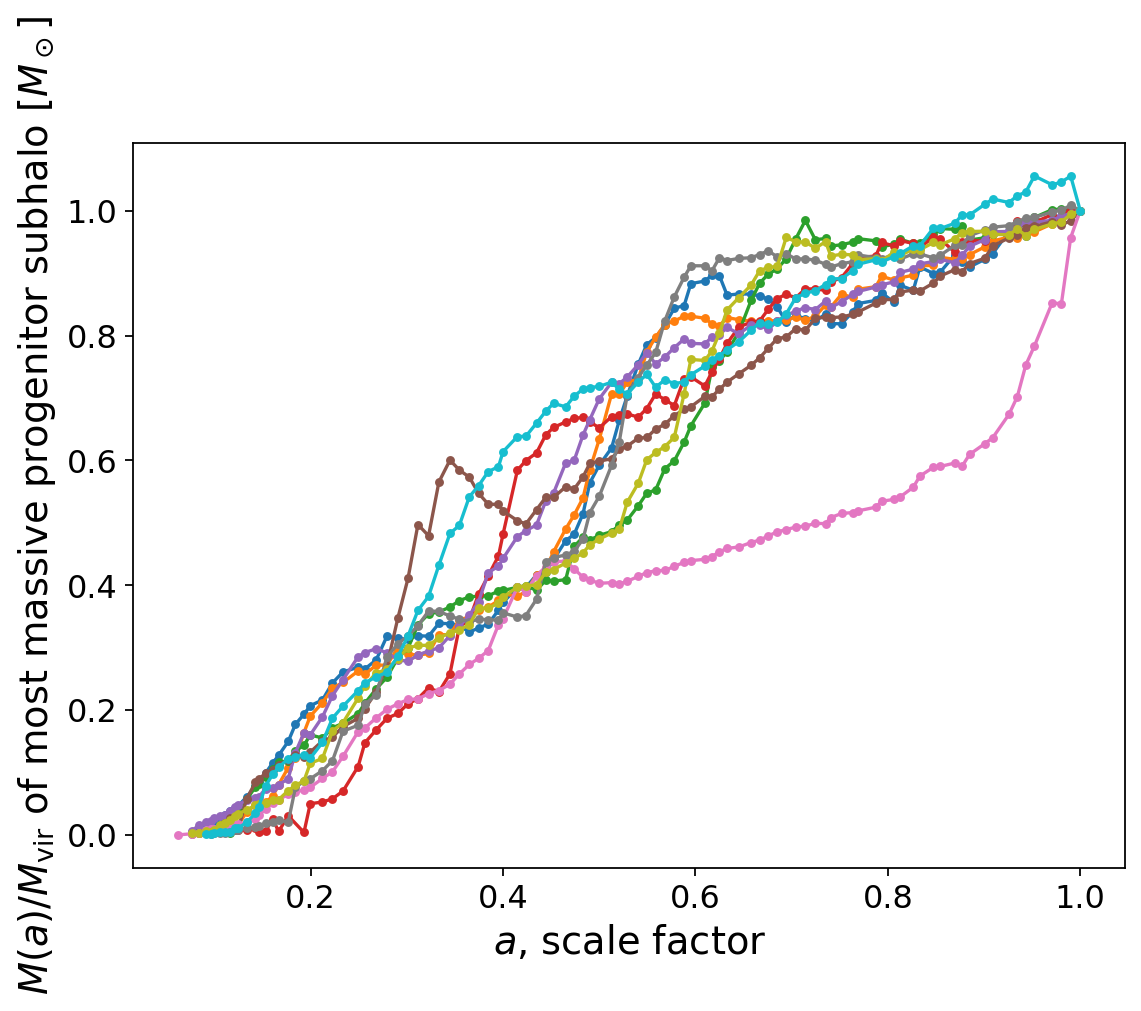

In [13]:
plt.figure(figsize=(8,6))
for i in rand_idxs:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3)
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M(a)/M_\mathrm{vir}$ of most massive progenitor subhalo [$M_\odot$]')

# MAH from SAM / ConsistentTrees

## Check SAM matches

In [14]:
mvir_sam = sim_reader.get_Mvir_SAM()

In [15]:
mass_multiplier_sam = 1e9
log_mass_shift_sam = 9

Text(0, 0.5, 'm_vir, SAM')

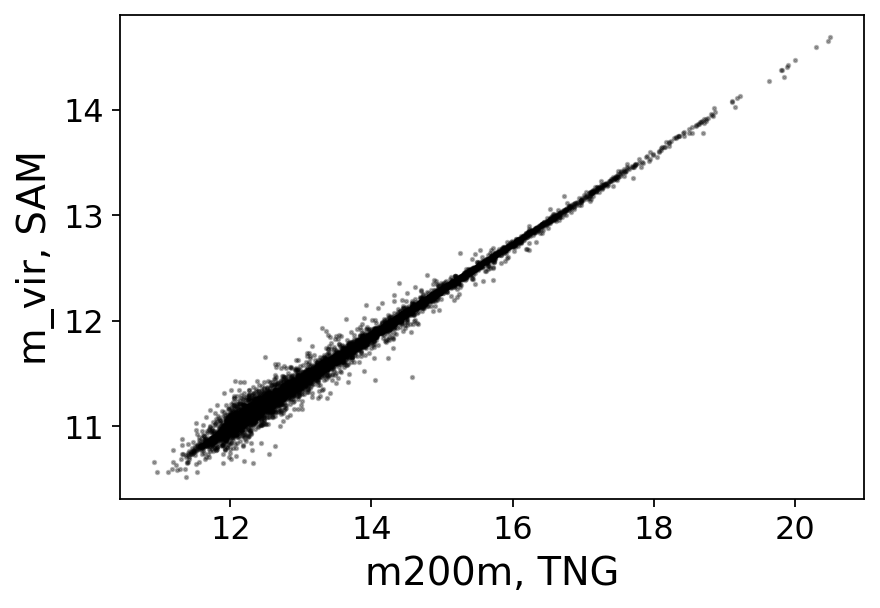

In [16]:
plt.scatter(np.log(m_200m)+log_mass_shift, np.log10(mvir_sam)+log_mass_shift_sam, color='k', alpha=0.3, s=2) 
plt.xlabel('m200m, TNG')
plt.ylabel('m_vir, SAM')

## Visualizing MAHs

In [17]:
# This will overwrite previous MAHs loaded into dark_halo_arr (eg from sublink above)
fn_mah = f'../data/mahs/mahs_SAM_{sim_name}{halo_tag}.npy'
if os.path.exists(fn_mah):
    load_mah(sim_reader.dark_halo_arr, fn_mah)
else:
    sim_reader.add_MAH_to_halos_SAM()
    save_mah(sim_reader.dark_halo_arr, fn_mah)

In [18]:
np.random.seed(14)
rand_idxs = np.random.randint(len(sim_reader.dark_halo_arr), size=10)

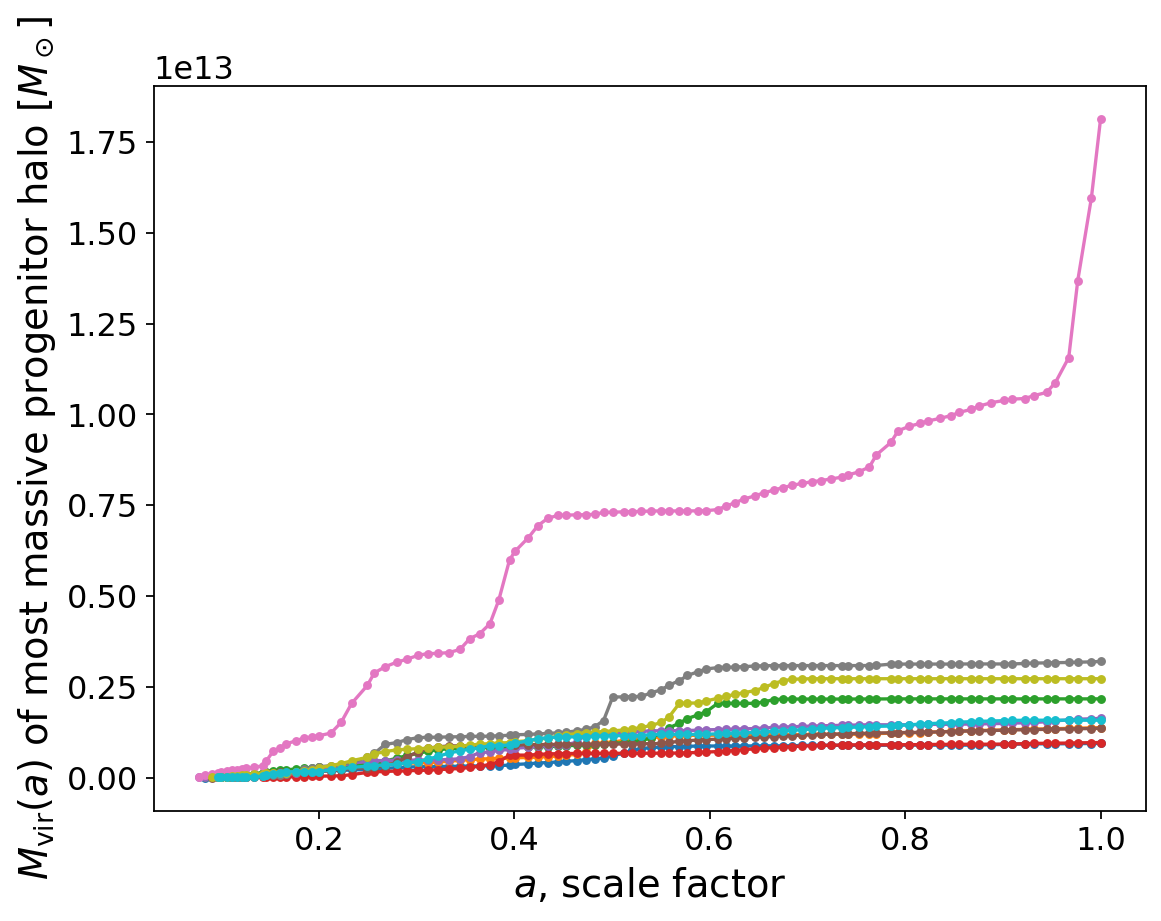

In [19]:
plt.figure(figsize=(8,6))
for i in rand_idxs:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah*mass_multiplier, marker='o', markersize=3)
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}(a)$ of most massive progenitor halo [$M_\odot$]')

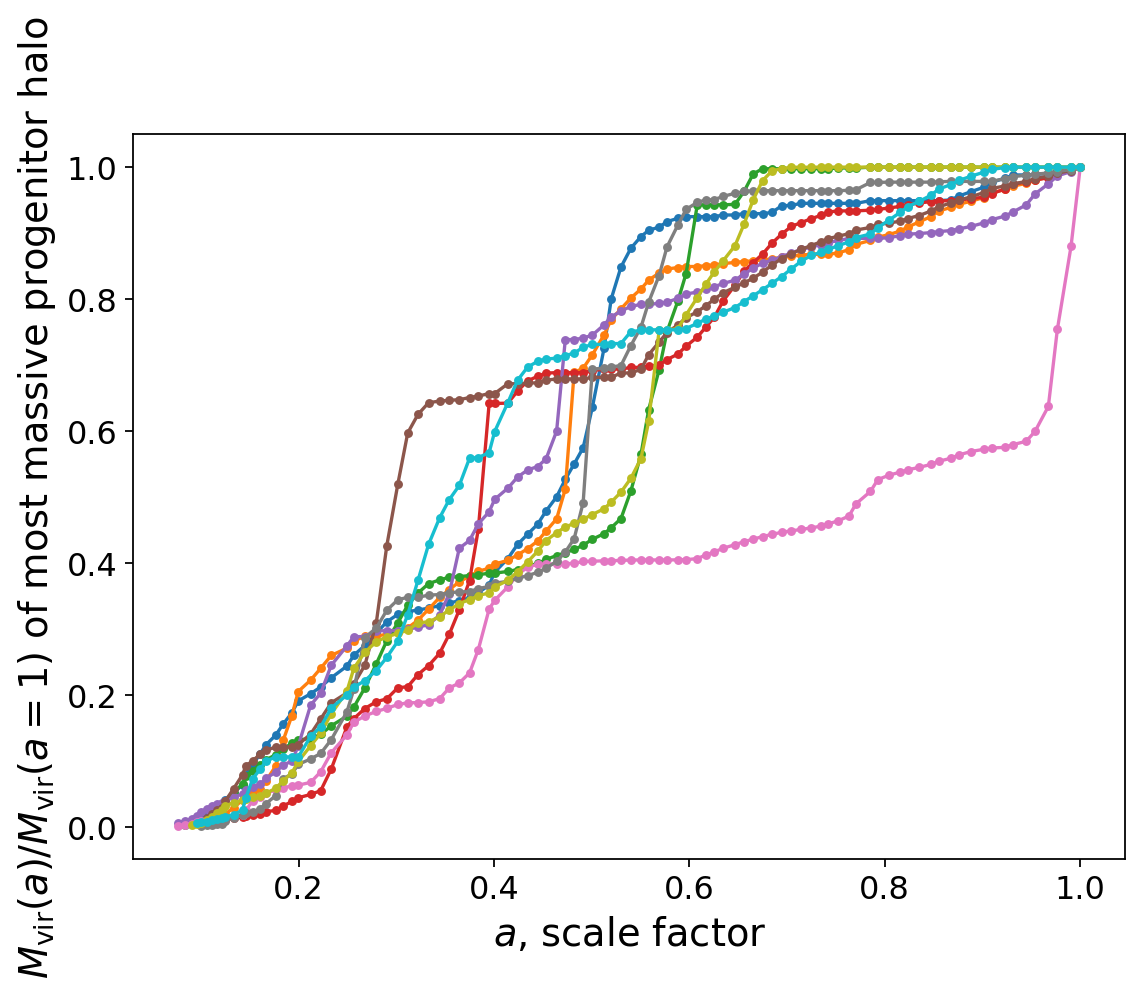

In [20]:
plt.figure(figsize=(8,6))
for i in rand_idxs:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3)
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

### Exploring a vs. m data

In [21]:
lens = []
a_first = []
for i, halo in enumerate(sim_reader.dark_halo_arr):
    lens.append(len(halo.catalog_properties['MAH'][0]))
    if len(halo.catalog_properties['MAH'][0]) > 0:
        a_first.append(halo.catalog_properties['MAH'][0][0])
        if halo.catalog_properties['MAH'][0][0]!=1.0:
            print(halo.catalog_properties['MAH'][0][0])

0.4730011
0.52997005
0.88829035
0.75254
0.86749005
0.3222397
0.5966199
0.72455
0.52002
0.7928102
0.5966199
0.7928102
0.7705799
0.41422963
0.7705799
0.6466699
0.62557006
0.5583302
0.58820003
0.57715
0.48205084
0.60803986
0.4730011
0.88829035
0.7419201
0.49127978
0.4532598
0.95372
0.60803986
0.3117304
0.75254
0.75254
0.5006799
0.5006799
0.54010993
0.60803986
0.7143199
0.8352202
0.7042402
0.66530985
0.8471798
0.88829035
0.7705799
0.30155995
0.6748399
0.9010097
0.72455
0.39506015
0.5006799
0.7419201


0


(array([  83.,  172.,  372.,  578.,  698., 1138., 1586., 1764., 2071.,
        2529., 2943., 4137., 1469.]),
 array([ 87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100]),
 [<matplotlib.patches.Polygon at 0x14a482ee8520>])

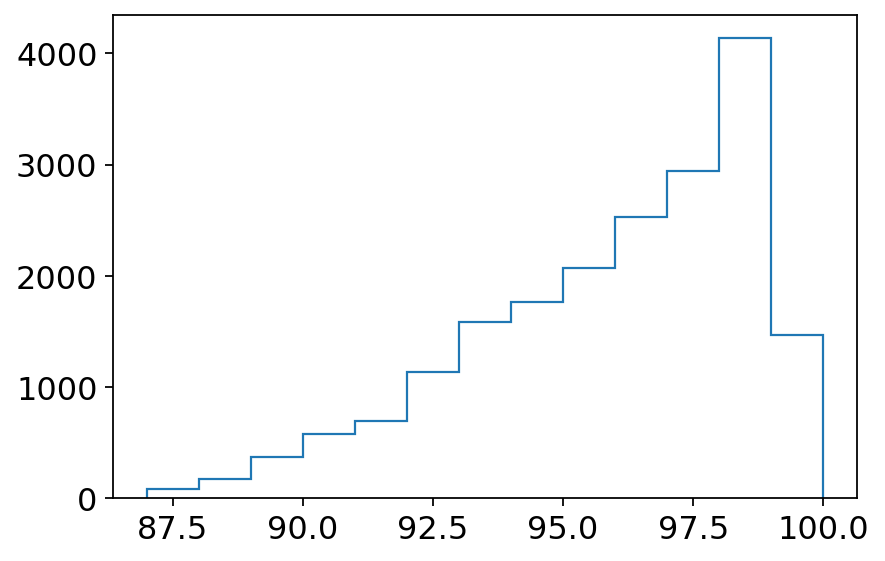

In [22]:
idx_len0 = lens==0
print(np.sum(idx_len0))
bins = np.arange(np.min(lens[~idx_len0]), np.max(lens)+1, 1)
plt.hist(lens, bins=bins, histtype='step')

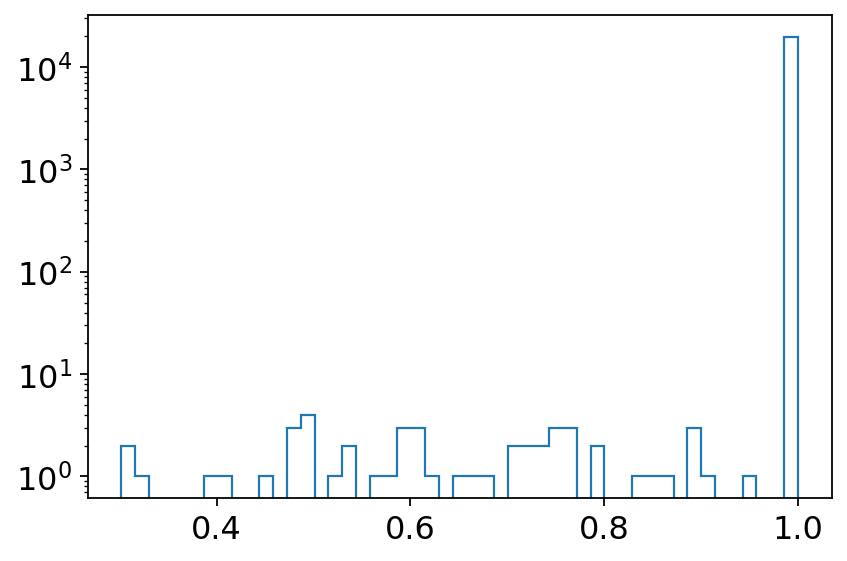

In [23]:
bins = np.linspace(np.min(a_first), np.max(a_first), 50)
plt.hist(a_first, bins=bins, histtype='step')
plt.yscale('log')

## Mass fraction at scale factor values, M(a)/M(a=1)

In [24]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [25]:
a_vals_target = [0.25, 0.5, 0.75]
a_vals = []
for halo in sim_reader.dark_halo_arr:
    if len(halo.catalog_properties['MAH'][0])==int(halo_params['sim']['snap_num_str'])+1:
        a_mah, m_mah = halo.catalog_properties['MAH']
        for i, a_val_target in enumerate(a_vals_target):
            a_near, i_a = find_nearest(a_mah, a_val_target)
            a_vals.append(a_near)
        break
print(a_vals)            

[0.24948981, 0.5006799, 0.75254]


In [26]:
percent_tol = 1
m_arrs = []
i_weirdmah = []
for a_val in a_vals:
    ms = np.zeros(len(sim_reader.dark_halo_arr))
    for i, halo in enumerate(sim_reader.dark_halo_arr):
        if len(halo.catalog_properties['MAH'][0])==0:
            continue
        a2m_dict = dict(zip(*halo.catalog_properties['MAH']))
        if a_val in a2m_dict and 1.0 in a2m_dict:
            ms[i] = a2m_dict[a_val]/a2m_dict[1.0]
            if ms[i]>5:
                i_weirdmah.append(i)
    print(np.sum(ms != 0))
    m_arrs.append(ms)
    

19594
19593
19593


Weird halos with progenitors > 5x more massive at any of the scale facs examined:

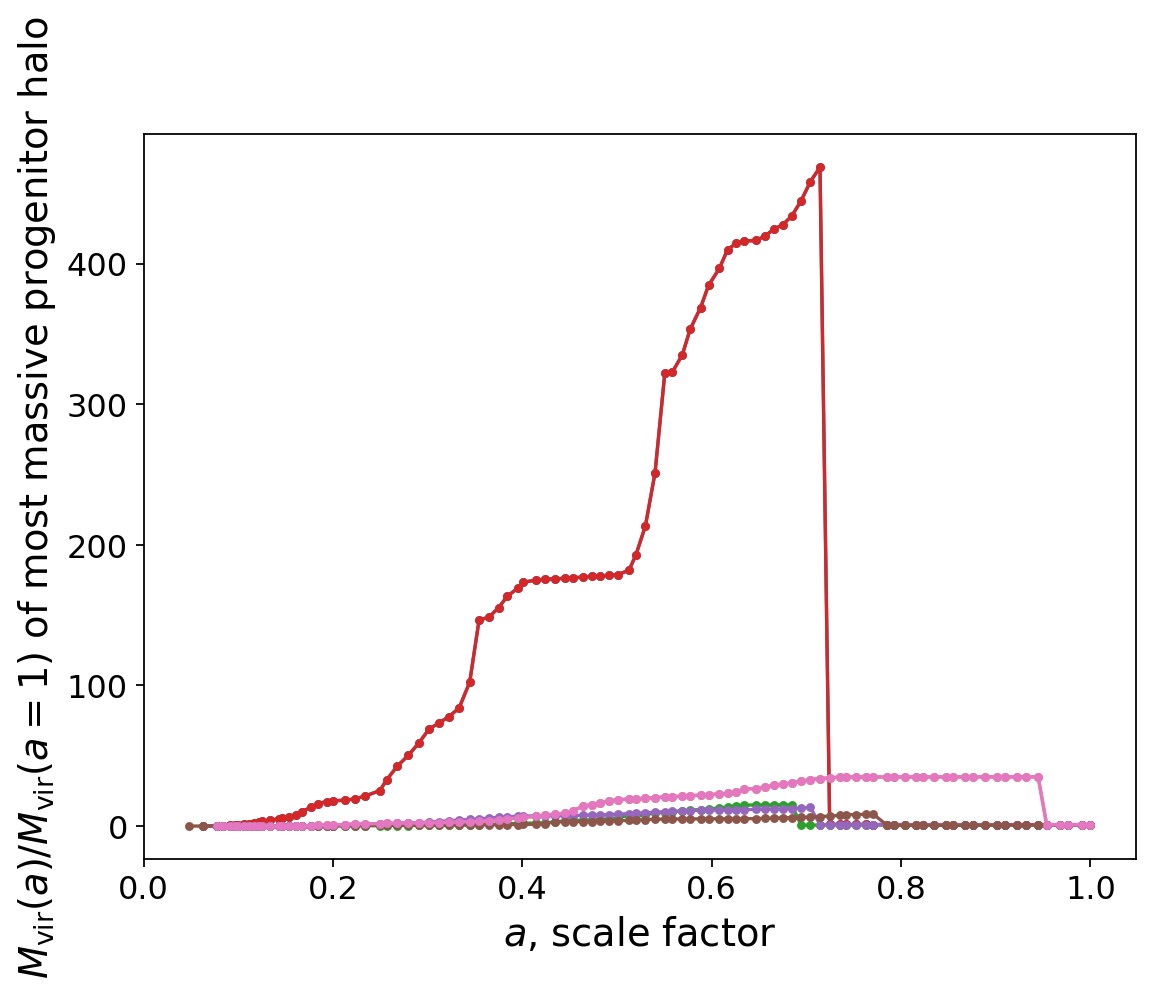

In [42]:
plt.figure(figsize=(8,6))
for i in i_weirdmah:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3)
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

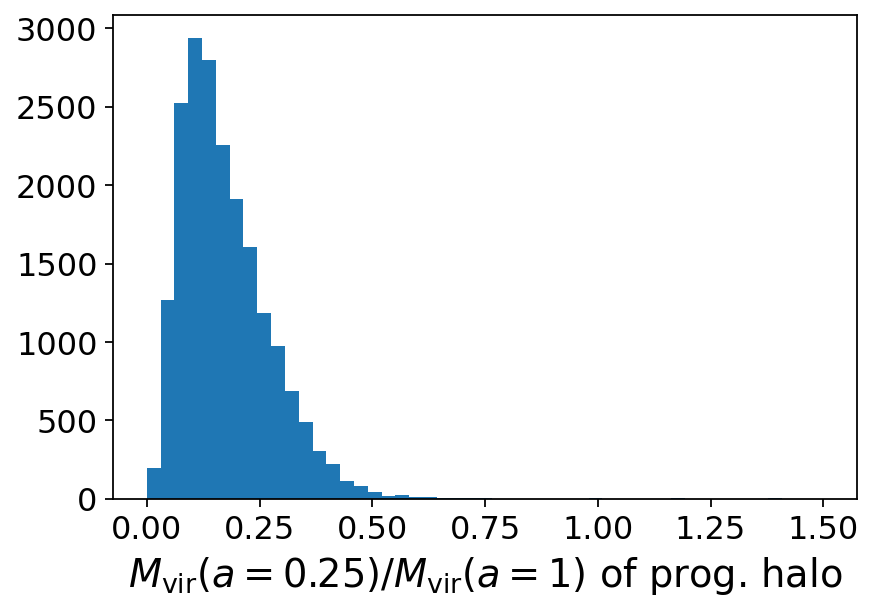

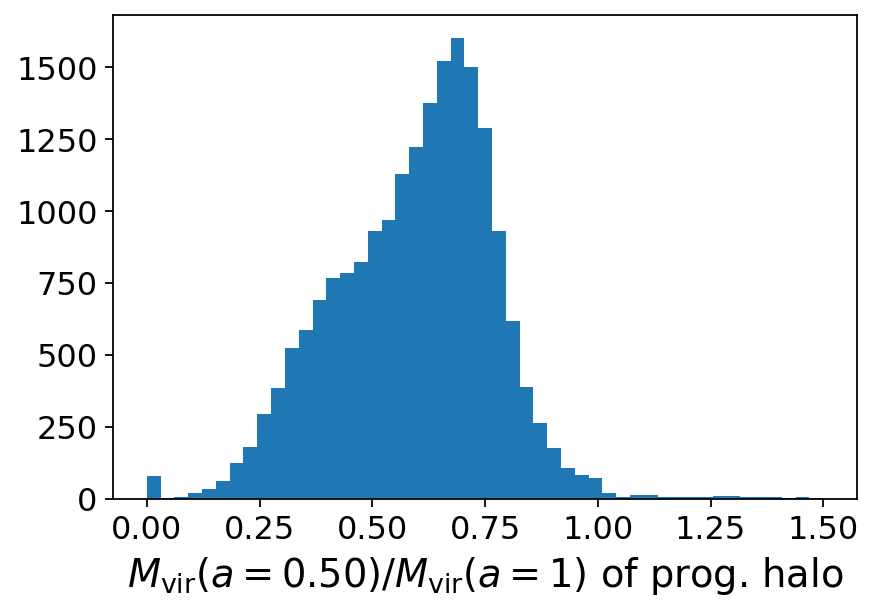

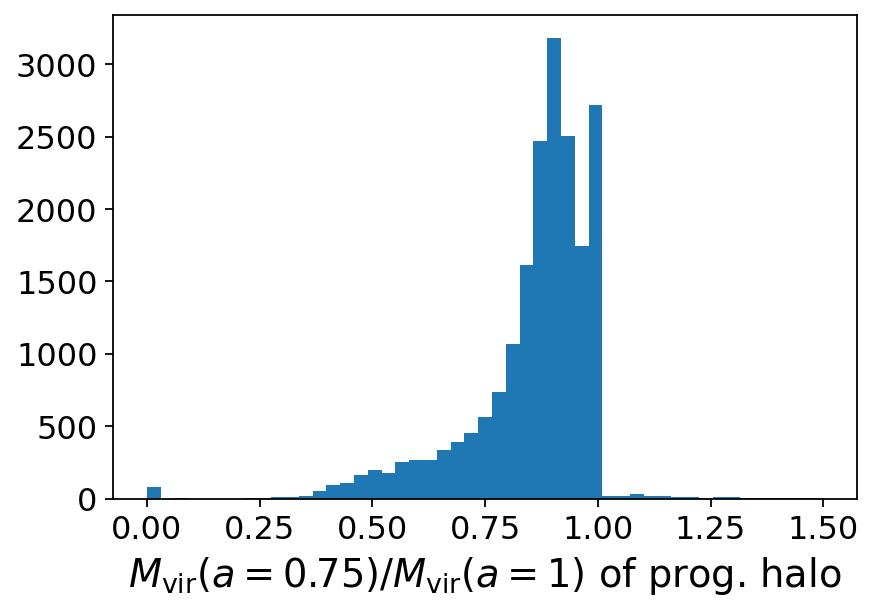

In [28]:
bins = np.linspace(0, 1.5, 50)
for i in range(len(a_vals)):
    plt.figure()
    plt.hist(m_arrs[i], bins=bins)
    plt.xlabel(rf'$M_\mathrm{{vir}}(a={a_vals[i]:.2f})/M_\mathrm{{vir}}(a=1)$ of prog. halo')
    #plt.xscale('log')
    #plt.yscale('log')

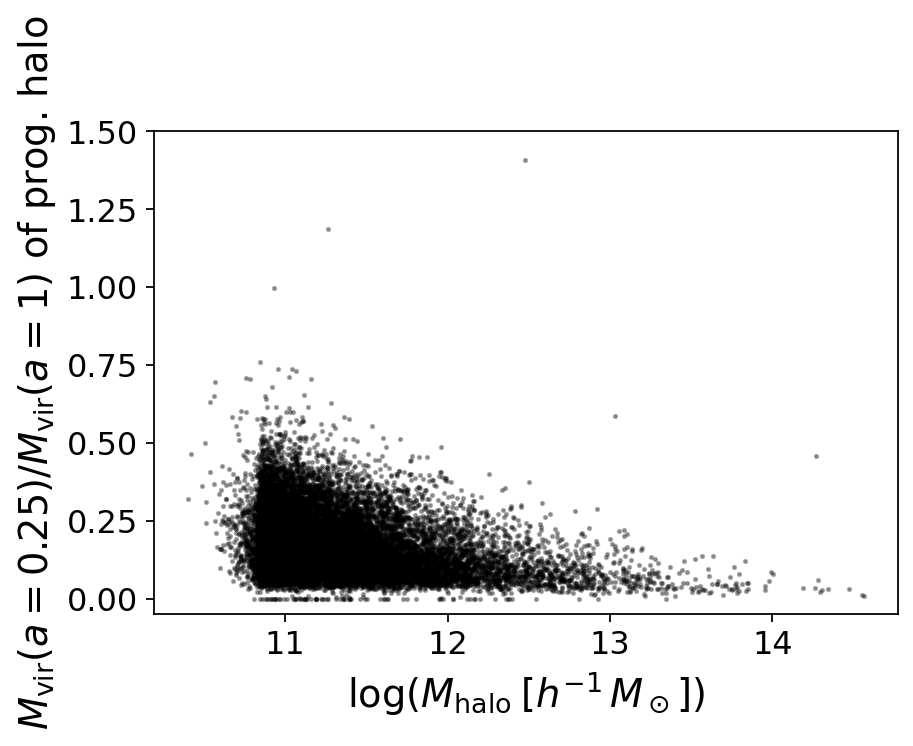

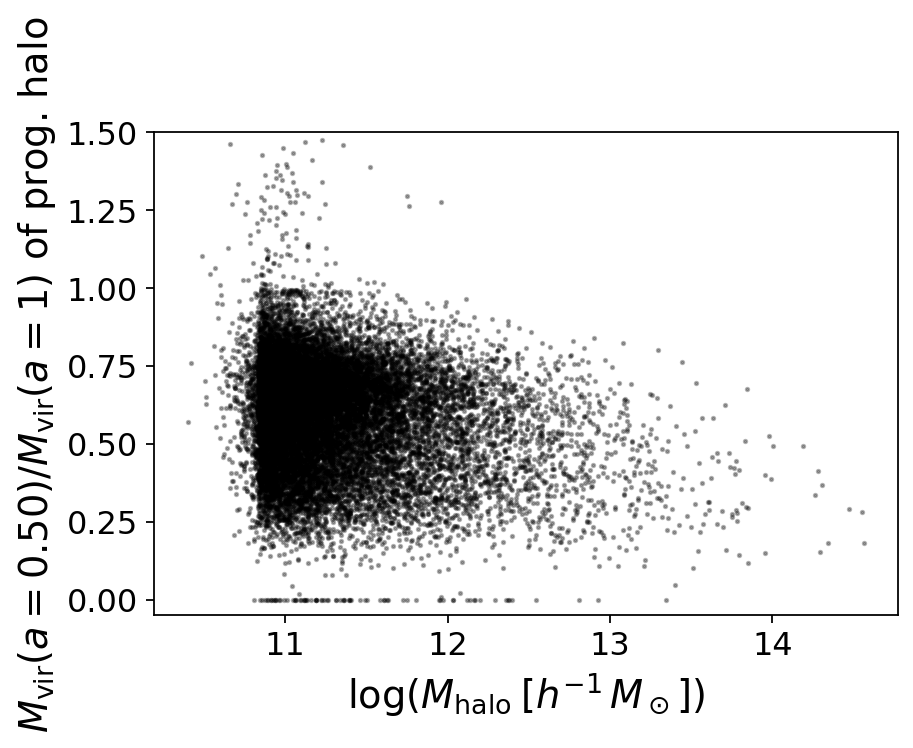

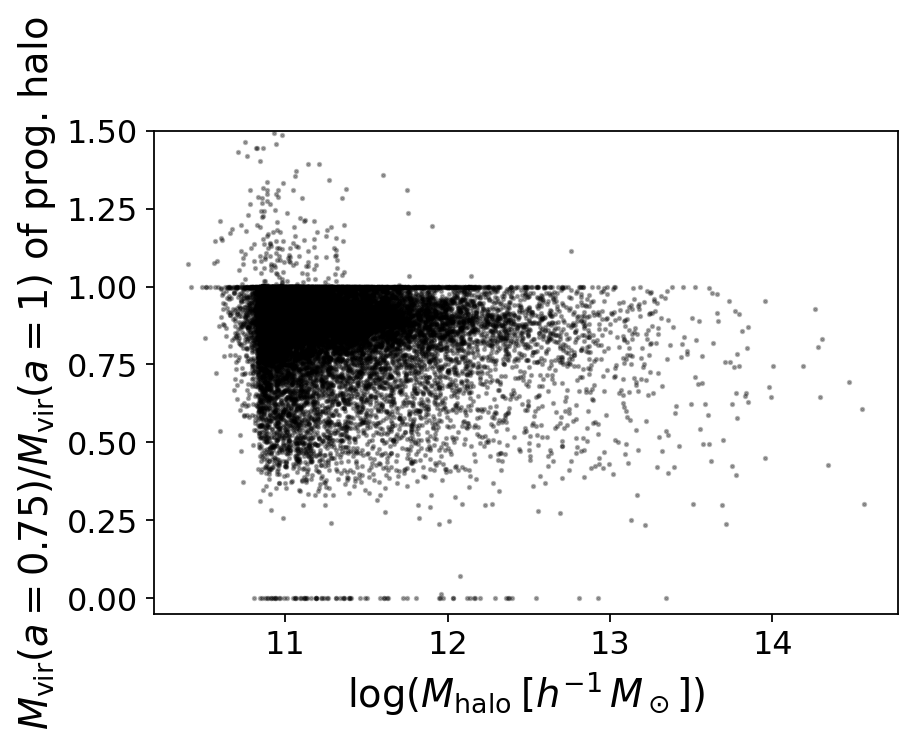

In [29]:
for i in range(len(a_vals)):
    plt.figure(figsize=(6, 4))
    plt.ylim(-0.05, 1.5)
    plt.scatter(log_m_200m + log_mass_shift, m_arrs[i],
                color='k', alpha=0.3, s=2)
    plt.xlabel(utils.label_dict['m_200m'])
    plt.ylabel(rf'$M_\mathrm{{vir}}(a={a_vals[i]:.2f})/M_\mathrm{{vir}}(a=1)$ of prog. halo')

# Scale factor when halo accumulated fraction of its mass, a(M=XM_a1)

In [30]:
# assumes y in reverse sorted order!! 
def y_interpolated(x, y, x_val):
    assert y[0]>y[1], "y def not in reverse sorted order!"
    x = np.array(x)
    y = np.array(y)
    idx_below = np.where(x<=x_val)[0]
    if len(idx_below)==0:
        return np.nan
    i_of_below = (np.abs(x[idx_below] - x_val)).argmin()
    i0 = idx_below[i_of_below]
    i1 = i0 - 1 #because reverse sorted order
    x0, x1 = x[i0], x[i1]
    y0, y1 = y[i0], y[i1]
    y_val_interp = (y0*(x1-x_val) + y1*(x_val-x0))/(x1-x0)   
    return y_val_interp

In [31]:
i_nonmono = []
a_mfrac_arrs = []
mfracs_target = [0.25, 0.5, 0.75]
for mfrac in mfracs_target:
    a_mfrac = np.full(len(sim_reader.dark_halo_arr), np.nan)
    for i, halo in enumerate(sim_reader.dark_halo_arr):
        if len(halo.catalog_properties['MAH'][0])==0:
            continue
        if 1.0 in halo.catalog_properties['MAH'][0]:
            i_a1 = (halo.catalog_properties['MAH'][0]==1.0)
            m_a1 = halo.catalog_properties['MAH'][1][i_a1]
            mfrac_interp = y_interpolated(halo.catalog_properties['MAH'][1]/m_a1, 
                                          halo.catalog_properties['MAH'][0], mfrac)
            if mfrac_interp < 0: #something went horribly wrong! check it out 
                i_nonmono.append(i)
                mfrac_interp = np.nan
            a_mfrac[i] = mfrac_interp
    a_mfrac_arrs.append(a_mfrac)

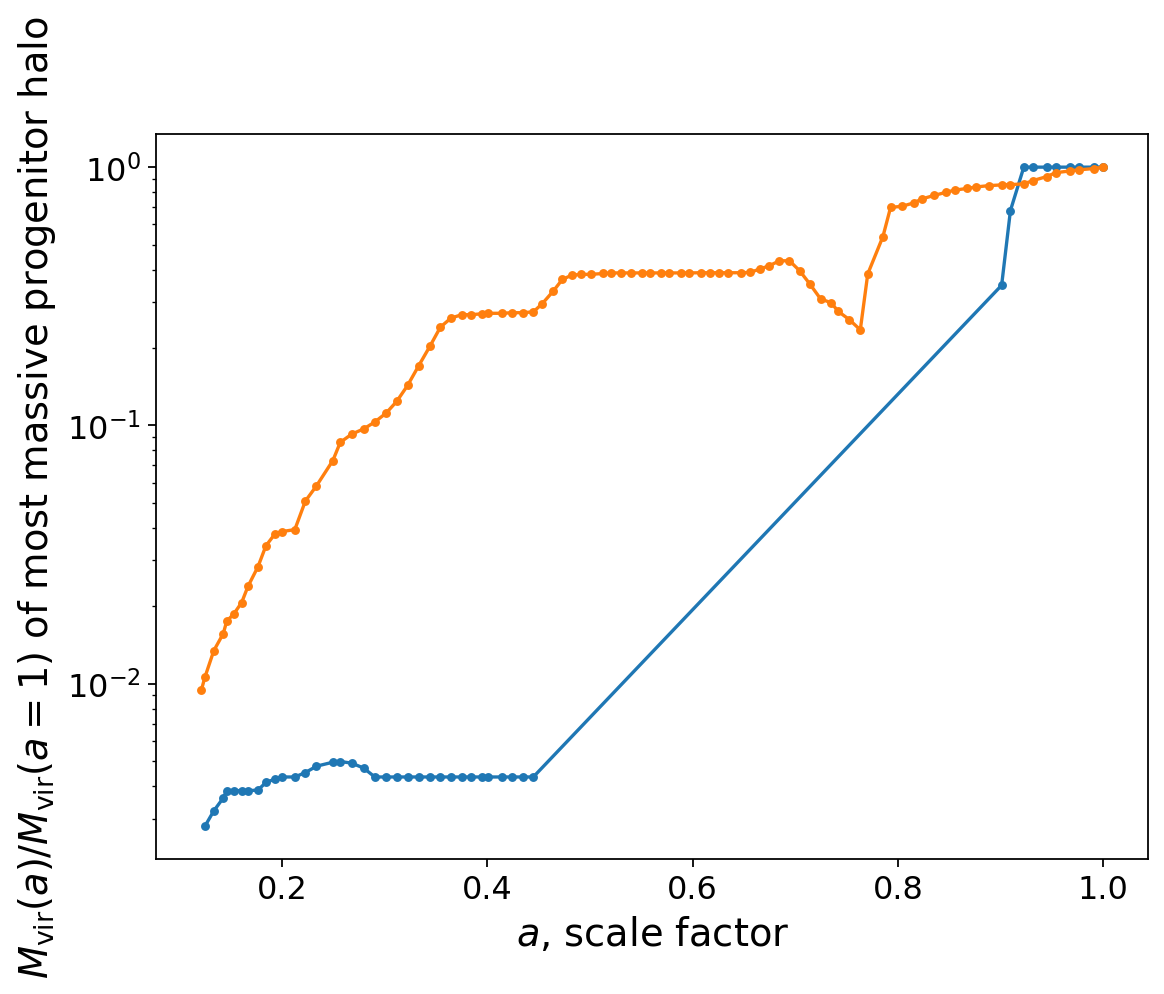

In [32]:
plt.figure(figsize=(8,6))
for i in i_nonmono:
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3)
    plt.yscale('log')
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

Num nans: 77
Num nans: 76
Num nans: 75


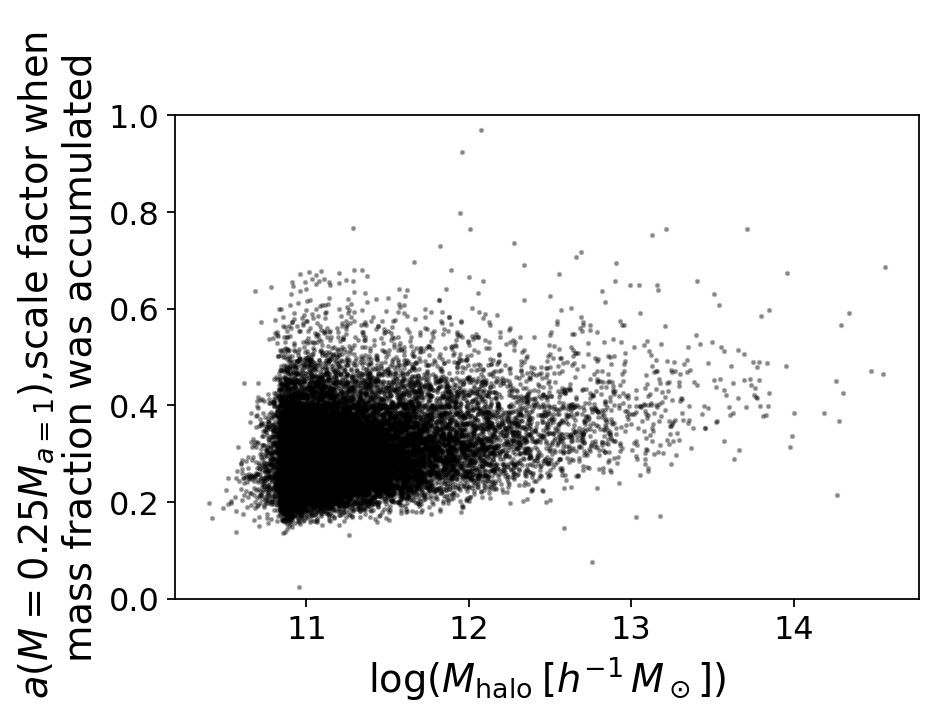

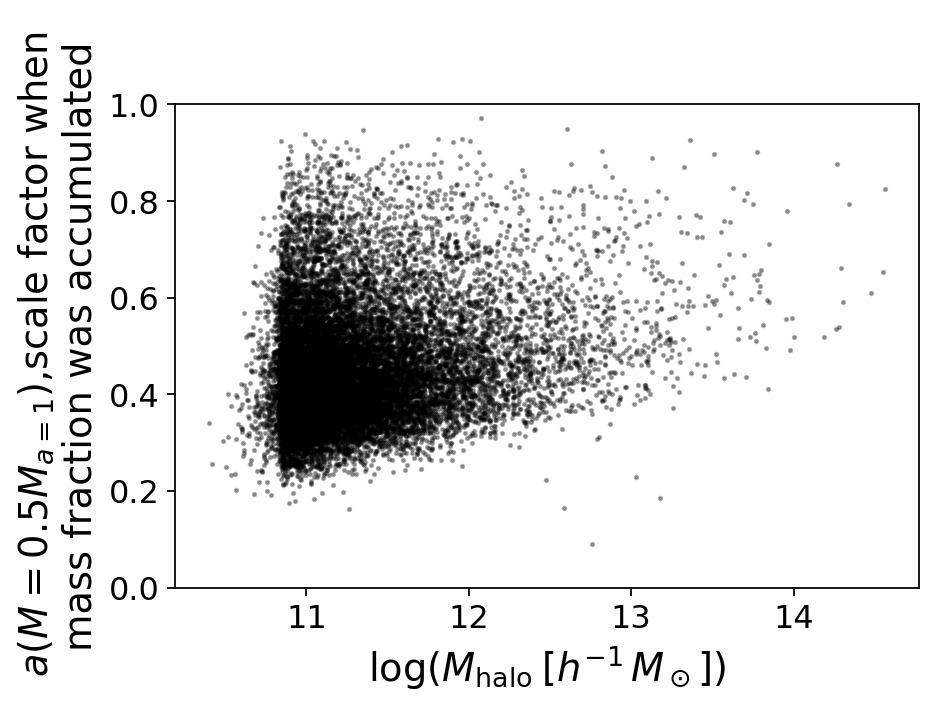

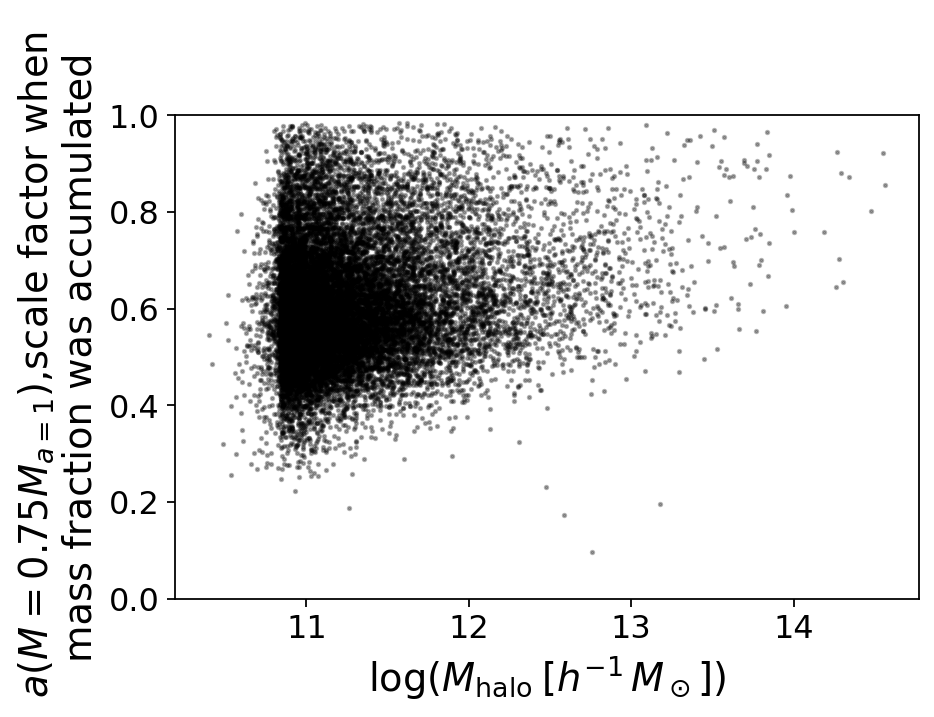

In [33]:
for i in range(len(mfracs_target)):
    plt.figure(figsize=(6, 4))
    print("Num nans:", np.count_nonzero(np.isnan(a_mfrac_arrs[i])))
    plt.scatter(log_m_200m + log_mass_shift, a_mfrac_arrs[i], 
                color='k', alpha=0.3, s=2)

    plt.xlabel(utils.label_dict['m_200m'])
    plt.ylabel(rf'$a(M={mfracs_target[i]}M_{{a=1}})$,' \
               'scale factor when  \nmass fraction was accumulated')
    plt.ylim(0,1)

## Load features

In [34]:
# geo info
geo_tag = ''
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)

../configs/geo_TNG100-1.yaml


In [35]:
scalar_tag = ''
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/scalar_TNG100-1.yaml


In [36]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

In [37]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [38]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [39]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [40]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Split train-val-test

In [41]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])

# Make predictions

For now, removing nans

a_mfrac
0.046549593903315443
0.023820422709399516 0.9251148675684222
-24.82986437268673 5.914720392056083
a_mfrac
0.06397504120870405
0.09047193056311321 0.9277486293386848
-23.4745305189565 18.395378706331925


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:317: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


a_mfrac
0.07283183902095697
0.09674987838839948 0.9849721693833488
-48.15288935726828 5.401884242213548


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:317: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


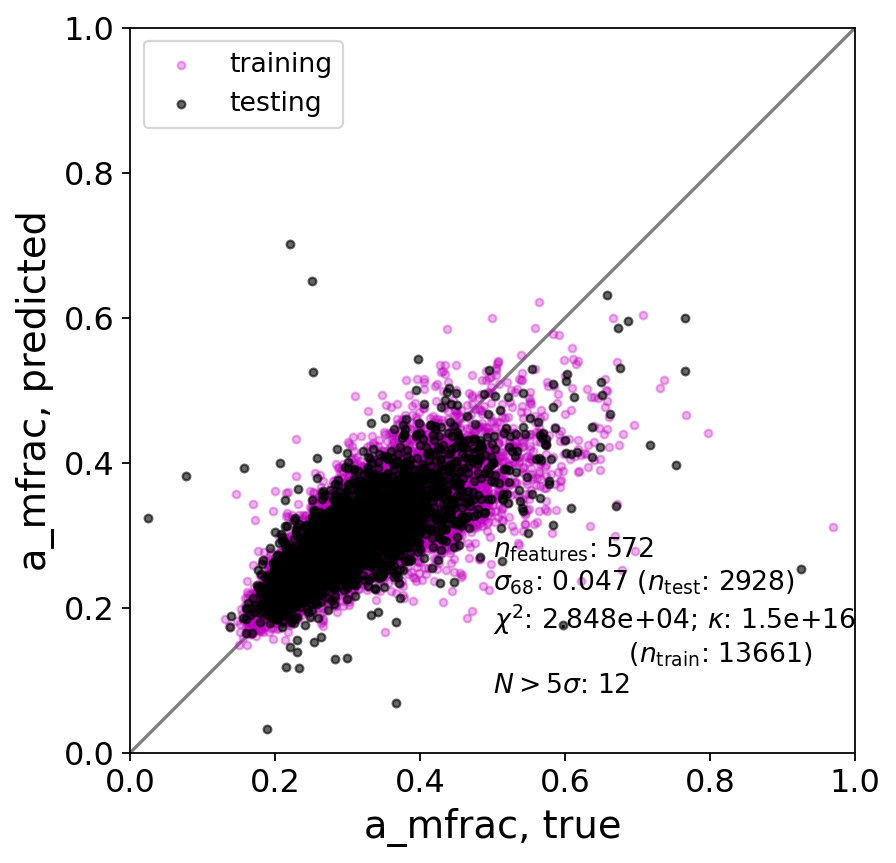

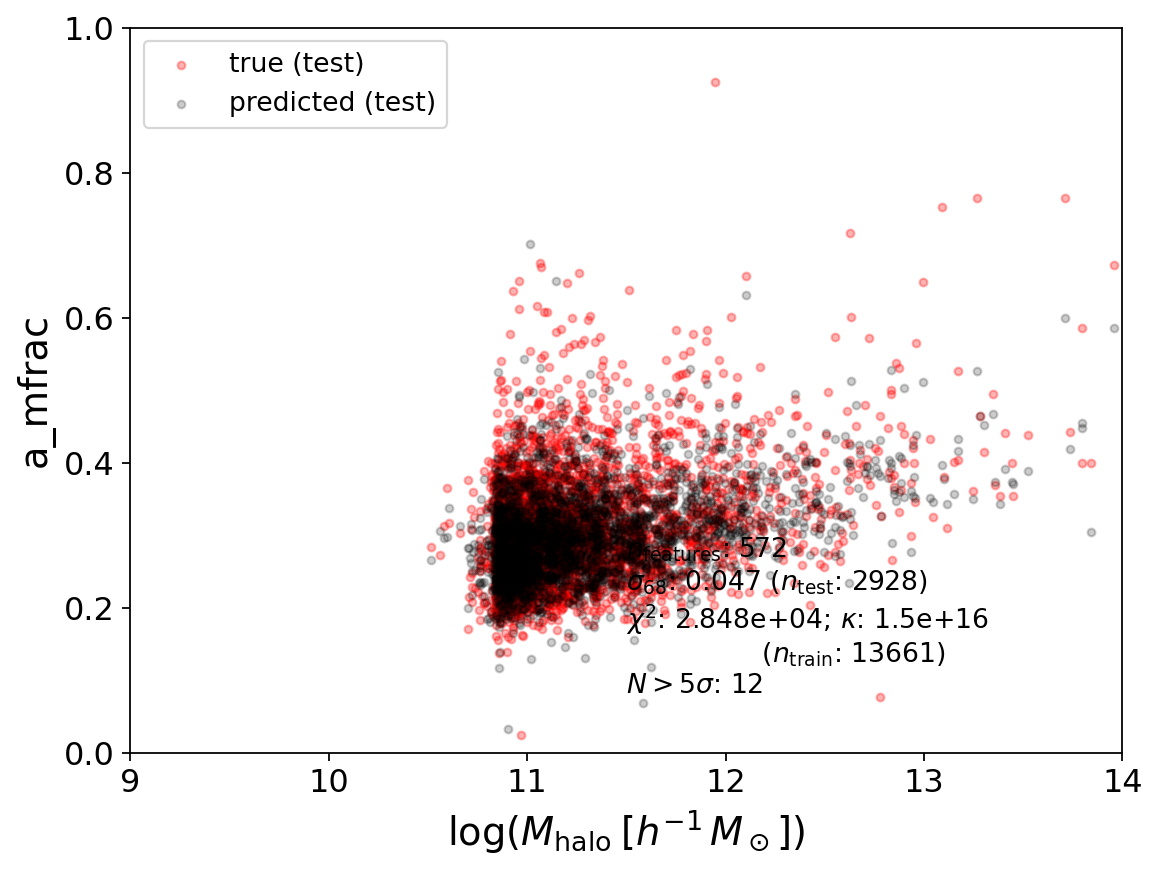

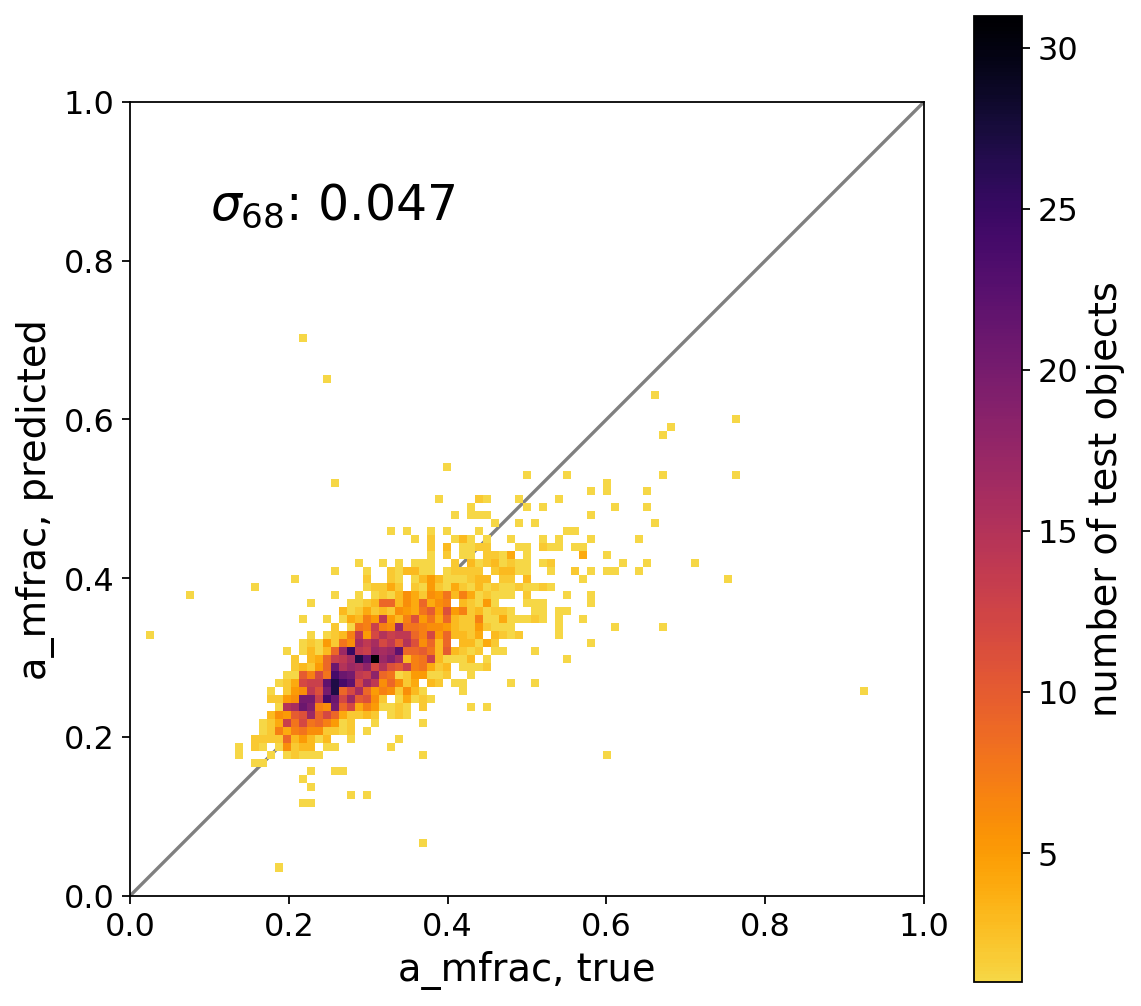

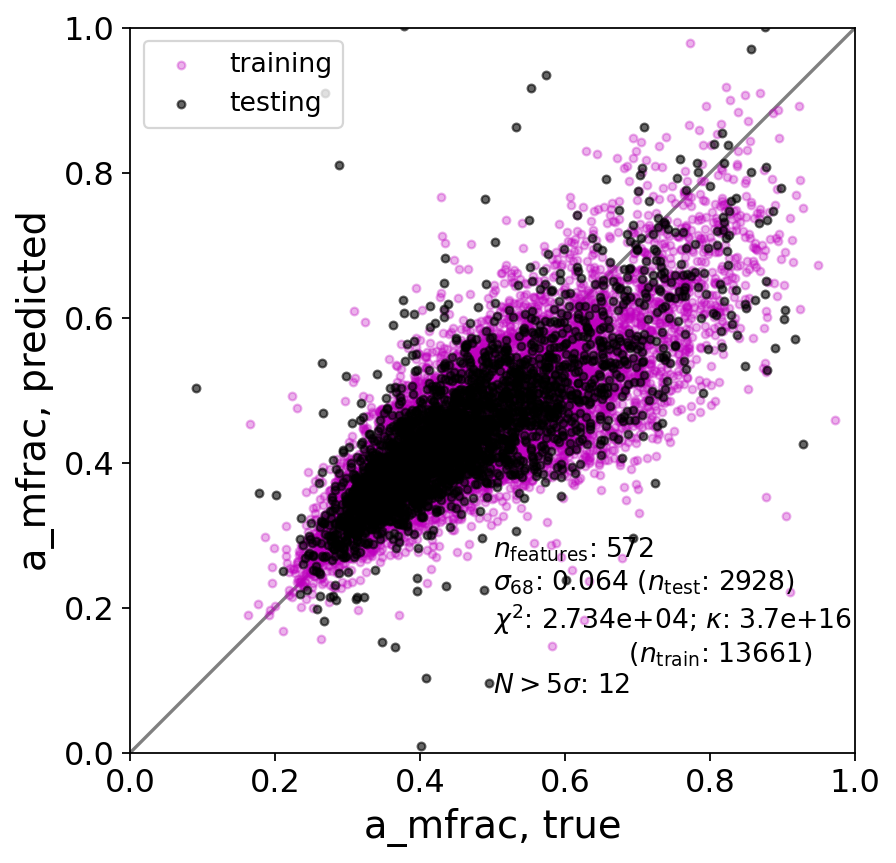

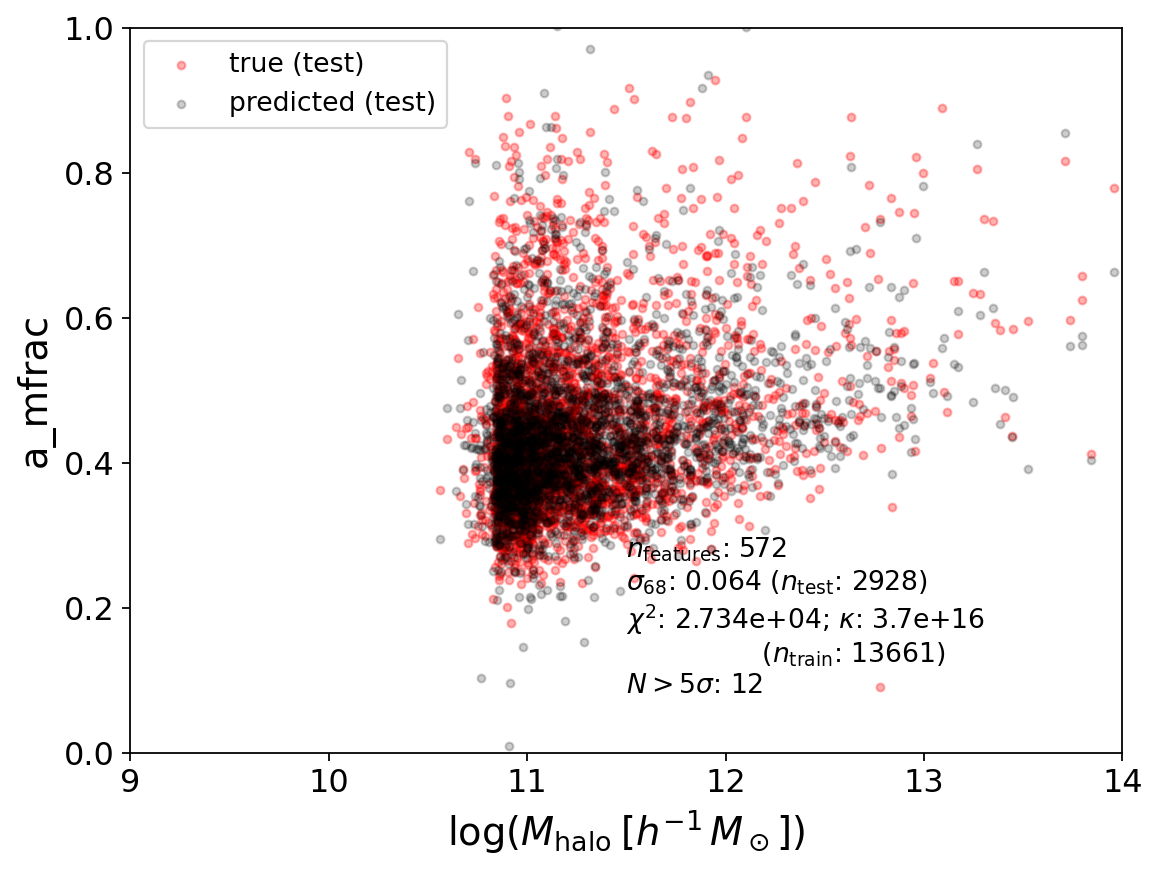

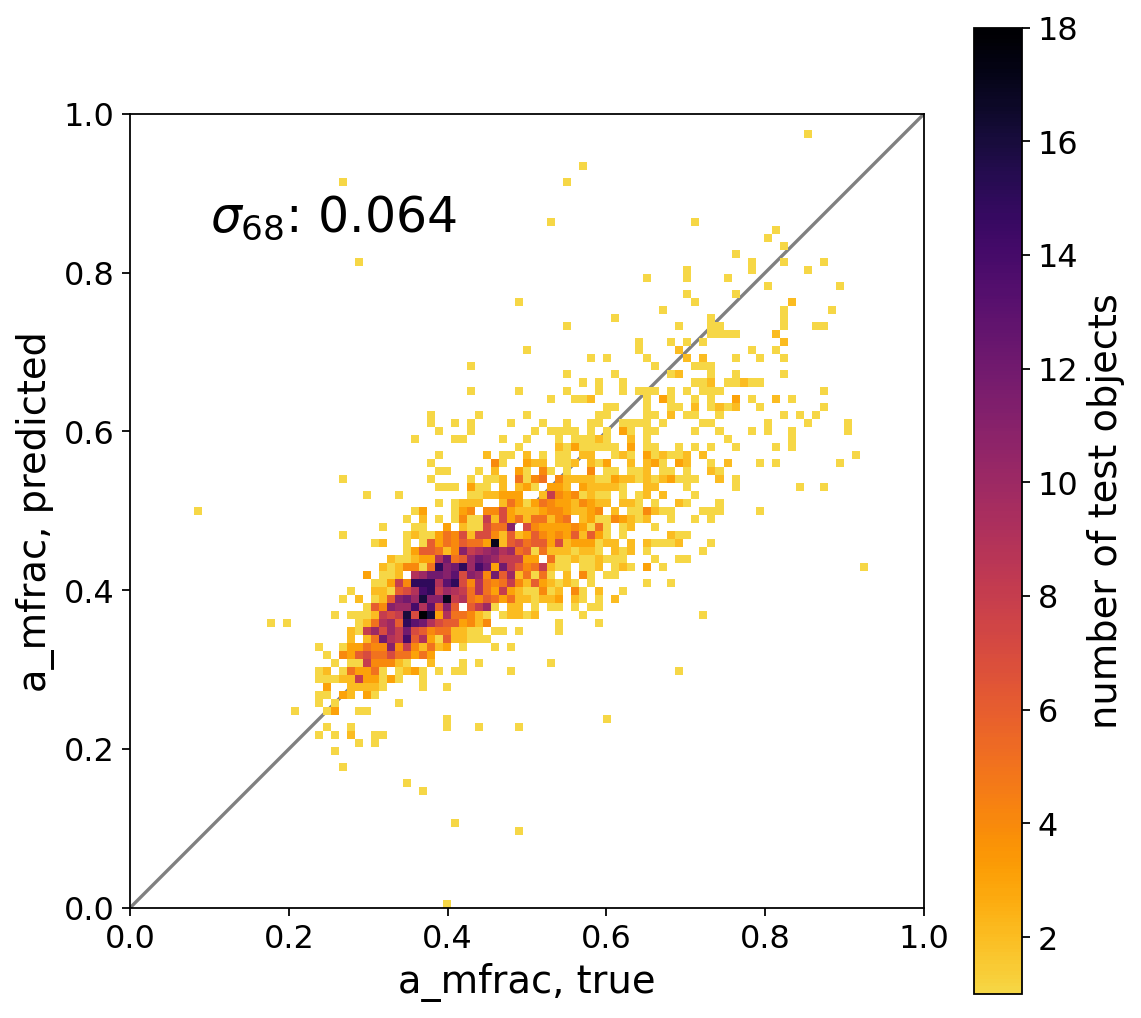

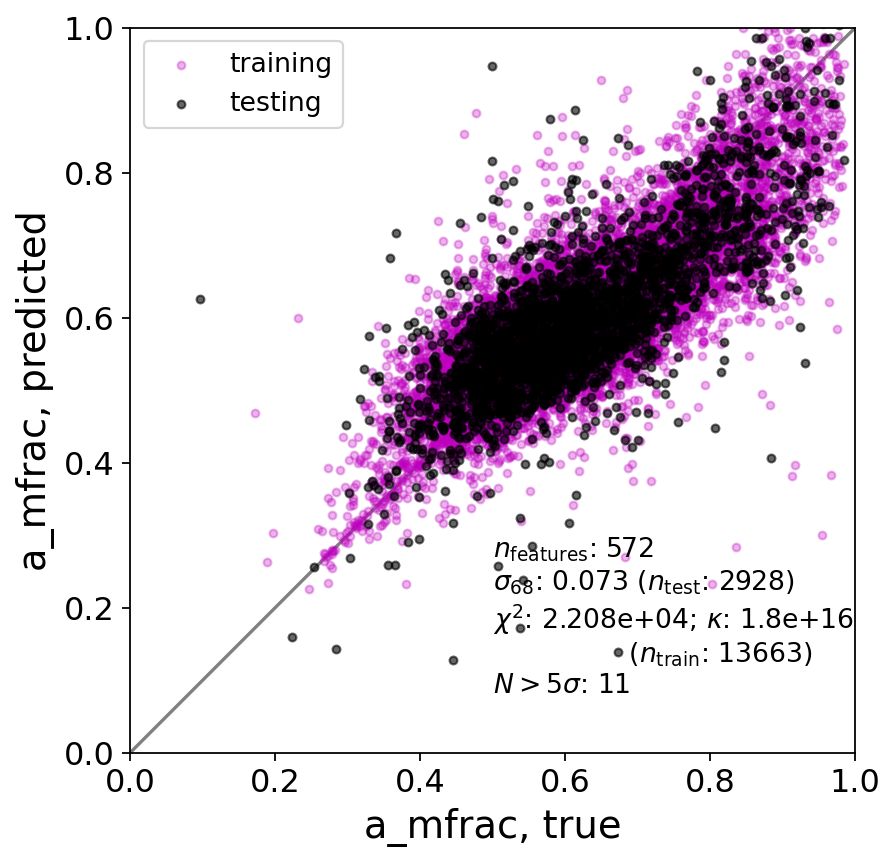

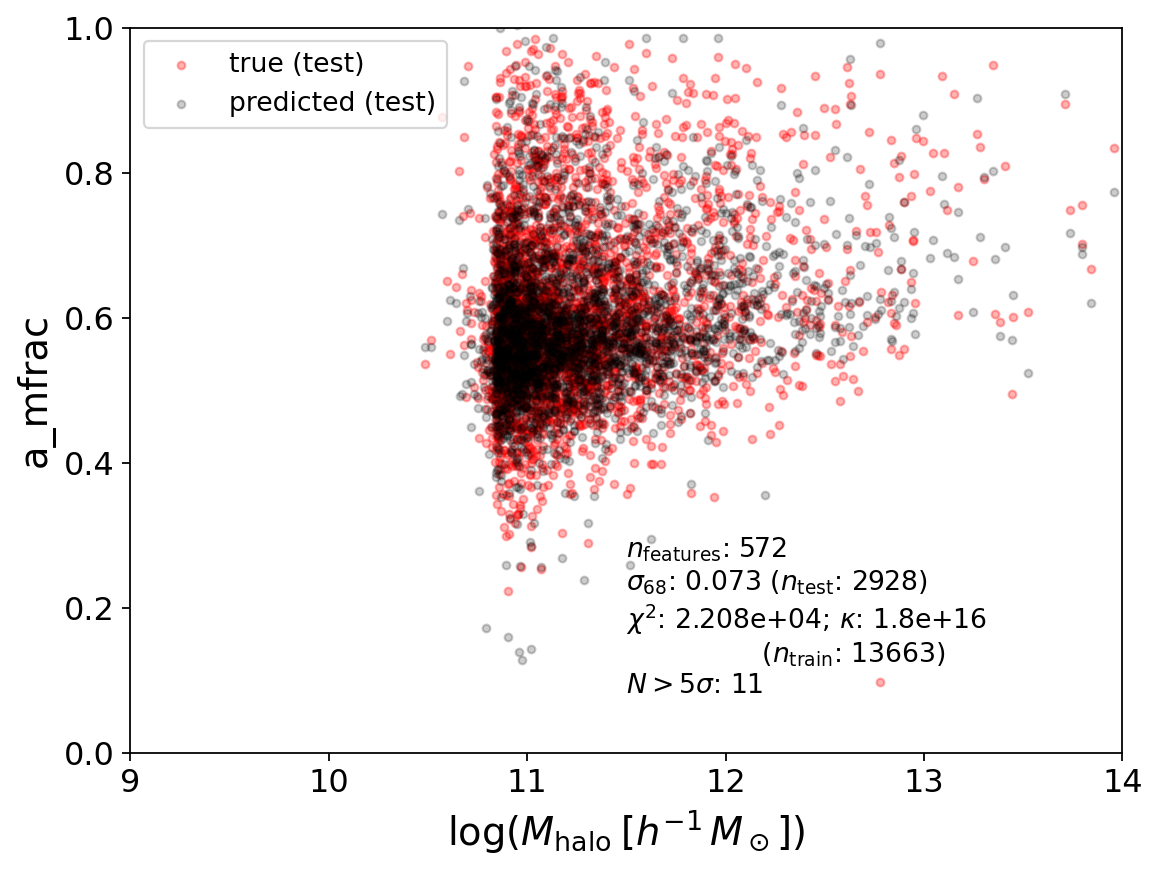

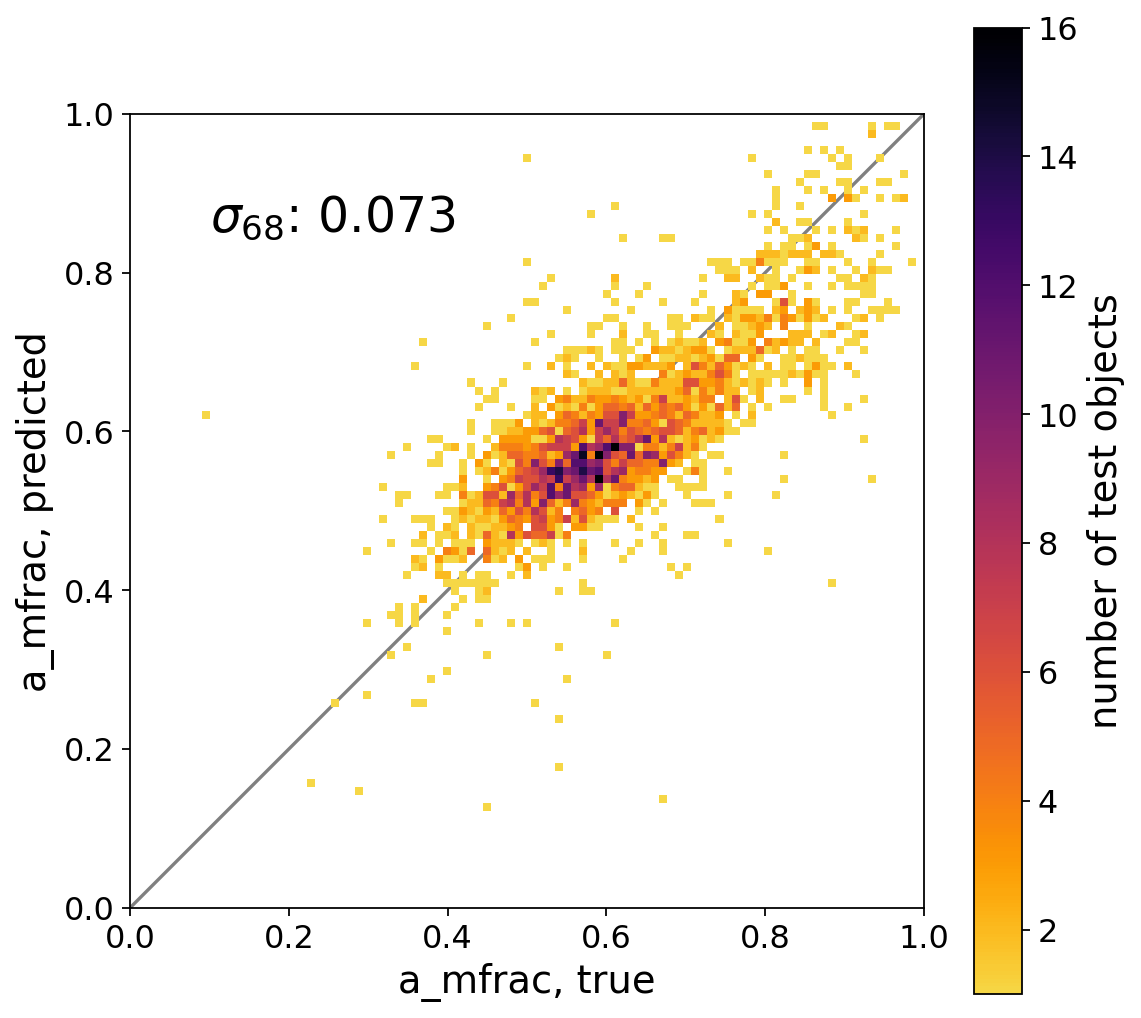

In [44]:
for i in range(len(mfracs_target)):
    x_label_name = 'm_200m'
    y_label_name = 'a_mfrac'
    
    y_label_vals = a_mfrac_arrs[i]
    
    idx_notnan = ~np.isnan(y_label_vals)
    y_label_vals = y_label_vals[idx_notnan]
    scalar_features_notnan = scalar_featurizer.scalar_features[idx_notnan]
    x_features_extra_notnan = x_features_extra[idx_notnan]    

    uncertainties_mah = 0.1 * y_label_vals
    y_val_current_mah = np.ones(len(y_label_vals))
    
    fitter_all = LinearFitter(scalar_features_notnan, y_label_vals, 
                        y_val_current_mah, uncertainties=uncertainties_mah,
                        x_features_extra=x_features_extra_notnan)
    
    idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints[idx_notnan], frac_train=frac_train, 
                                                          frac_val=frac_val, frac_test=frac_test)
    fitter_all.split_train_test(idx_train, idx_val)
    fitter_all.scale_and_fit(rms_x=True, log_x=False, log_y=False)
    fitter_all.predict_test()
    
    plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m, x_lim=(9,14),  y_lim=(0,1))
    error_all, _ = utils.compute_error(fitter_all, test_error_type='percentile')
    print(error_all)
    
    y_true = fitter_all.y_scalar_test
    y_pred = fitter_all.y_scalar_pred
    print(np.min(y_true), np.max(y_true))
    print(np.min(y_pred), np.max(y_pred))
    error_str = fr"$\sigma_{{68}}$: {error_all:.3f}"
    plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
                                   x_lim=(0,1),  y_lim=(0,1))

In [ ]:
# for i in range(len(mfracs_target)):
# #for i in range(1,3):
#     x_label_name = 'm_200m'
#     y_label_name = 'a_mfrac'
    
#     #y_label_vals = np.log10(m_arrs[i])
#     y_label_vals = a_mfrac_arrs[i]
    
#     #idx_zero = y_label_vals == 0
#     #print(np.sum(idx_zero)/len(idx_zero))
#     #y_label_vals[idx_zero] = 6 - log_mass_shift

#     #uncertainty_floor = 0.05
#     #uncertainties_mah = np.sqrt((0.1 * y_label_vals)**2 + (uncertainty_floor)**2) 
#     uncertainties_mah = np.full(len(y_label_vals), 0.05)

#     y_val_current_mah = np.ones(len(y_label_vals))
    
#     fitter_all = LinearFitter(scalar_featurizer.scalar_features, y_label_vals, 
#                         y_val_current_mah, uncertainties=uncertainties_mah,
#                         x_features_extra=x_features_extra)
#     fitter_all.split_train_test(idx_train, idx_val)
#     fitter_all.scale_and_fit(rms_x=False, log_x=False, log_y=False)
#     fitter_all.predict_test()
#     #plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m, x_lim=(9,14),  y_lim=(0,1))
#     error_all, _ = utils.compute_error(fitter_all, test_error_type='percentile')
#     #print(error_all)
    
#     y_true = fitter_all.y_scalar_test
#     y_pred = fitter_all.y_scalar_pred
#     #print(np.min(y_true), np.max(y_true))
#     #print(np.min(y_pred), np.max(y_pred))
#     error_str = fr"$\sigma_{{68}}$: {error_all:.3f}"
#     plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
#                                    x_lim=(0,1),  y_lim=(0,1))

# Neural net

TODO: custom loss function that takes into account uncertainties, for all nns!! 

In [50]:
from torch.utils.data import DataLoader

Training epoch 0
  batch 427 loss: -0.11661198078957488
Training epoch 1
  batch 427 loss: -0.7701728228296851
Training epoch 2
  batch 427 loss: -0.7714449909288306
Training epoch 3
  batch 427 loss: -0.8800962489172514
Training epoch 4
  batch 427 loss: -0.8586691050086588
Training epoch 5
  batch 427 loss: -0.8402405051297528
Training epoch 6
  batch 427 loss: -0.9011026518091548
Training epoch 7
  batch 427 loss: -0.8421040734784733
Training epoch 8
  batch 427 loss: -0.8745681952015826
Training epoch 9
  batch 427 loss: -0.8890038056801288
Training epoch 10
  batch 427 loss: -0.8874568429819268
Training epoch 11
  batch 427 loss: -0.898489559615881
Training epoch 12
  batch 427 loss: -0.8782104340188622
Training epoch 13
  batch 427 loss: -0.8981483810705796
Training epoch 14
  batch 427 loss: -0.8801804529602083
Training epoch 15
  batch 427 loss: -0.9029563411598113
Training epoch 16
  batch 427 loss: -0.8957428313506061
Training epoch 17
  batch 427 loss: -0.8909483991939608
Tr

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:317: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


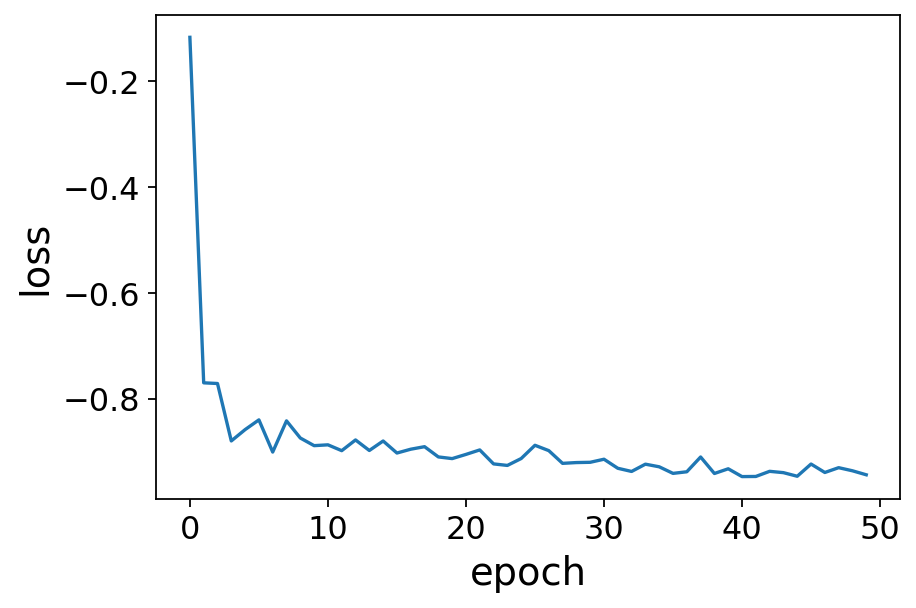

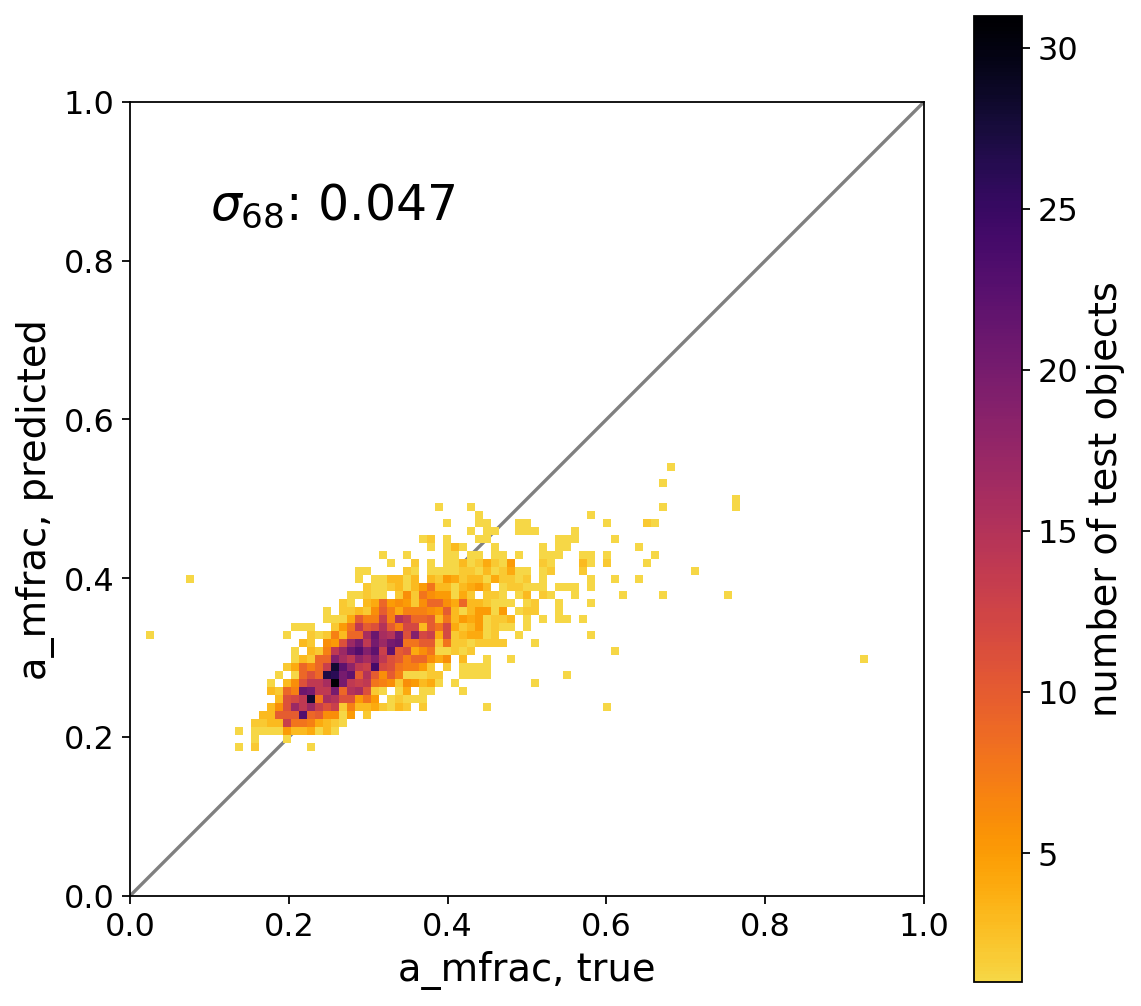

In [68]:
from neural_net import NeuralNet, NNFitter
#for i in range(len(mfracs_target)):
for i in range(1):
    x_label_name = 'm_200m'
    y_label_name = 'a_mfrac'
    
    y_label_vals = a_mfrac_arrs[i]
    
    idx_notnan = ~np.isnan(y_label_vals)
    y_label_vals = y_label_vals[idx_notnan]
    scalar_features_notnan = scalar_featurizer.scalar_features[idx_notnan]
    x_features_extra_notnan = x_features_extra[idx_notnan]    

    uncertainties_mah = 0.1 * y_label_vals
    y_val_current_mah = np.ones(len(y_label_vals))
    
    
    nnfitter = NNFitter(scalar_features_notnan, y_label_vals,
                        y_val_current_mah, x_features_extra=x_features_extra_notnan,
                        uncertainties=uncertainties_mah)
    idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints[idx_notnan], frac_train=frac_train, 
                                                          frac_val=frac_val, frac_test=frac_test)
    nnfitter.split_train_test(idx_train, idx_val)
    nnfitter.set_up_data()
    nnfitter.data_loader_train = DataLoader(nnfitter.dataset_train, 
                                          batch_size=32, shuffle=True,
                                          #worker_init_fn=seed_worker,
                                          #generator=g, 
                                          num_workers=0)
    
    input_size = nnfitter.n_A_features
    hidden_size = 128
    nnfitter.model = NeuralNet(input_size, hidden_size=hidden_size)
    nnfitter.train(max_epochs=50, learning_rate=0.00005)
    
    plt.figure()
    plt.plot(nnfitter.loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    nnfitter.predict_test()
    
    error_nn, _ = utils.compute_error(nnfitter, test_error_type='percentile')
    y_true = nnfitter.y_scalar_test
    y_pred = nnfitter.y_scalar_pred
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f}"
    plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
                                   x_lim=(0,1),  y_lim=(0,1))

# 